In [ ]:
import torch
from torch.utils.data import DataLoader
from datasets import load_dataset
from transformers import AutoTokenizer

# Load the TinyStories dataset
#dataset = load_dataset("roneneldan/TinyStories")
# Load the WikiText-103 dataset
dataset = load_dataset("wikitext", "wikitext-103-raw-v1")

tokenizer = AutoTokenizer.from_pretrained("gpt2")  # or any suitable tokenizer
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
vocab_size=tokenizer.vocab_size+1
print(f"vocab_size: {tokenizer.vocab_size}")

# Preprocess the dataset
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=64)
tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets.set_format("torch")  

device="cuda" if torch.cuda.is_available() else "cpu"

Repo card metadata block was not found. Setting CardData to empty.


vocab_size: 30522


In [2]:
from continous_diffusion.diffusion import DiffusionModel

# embed_dim, hidden_dim, qkv_dim, num_heads, cond_dim, n_blocks = 256, 1024, 1024, 8, 128, 8 #paper parameters (not sure about qkv_dim)  
# embed_dim, hidden_dim, qkv_dim, num_heads, cond_dim, n_blocks = 64, 256, 2048, 16, 128, 20  
# embed_dim, hidden_dim, qkv_dim, num_heads, cond_dim, n_blocks = 64, 256, 1024, 16, 64, 8 
# embed_dim, hidden_dim, qkv_dim, num_heads, cond_dim, n_blocks = 64, 128, 512, 8, 64, 2  
model=DiffusionModel(embed_dim,hidden_dim,qkv_dim,num_heads,cond_dim,n_blocks,tokenizer,p_self_cond=0.4,p_mask_cond=0.1,p_mask=1,prefix=0).to(device)


/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.12.1-git20200711.33e2d80-dfsg1-0.6 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/usr/lib/python3/dist-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [3]:
# DataLoader
train_loader = DataLoader(tokenized_datasets["train"], batch_size=512, shuffle=True)
optimizer = torch.optim.AdamW(model.parameters(),lr=5e-3)

# Learning-rate scheduling
from torch.optim.lr_scheduler import SequentialLR, LinearLR, ExponentialLR

n_epochs=3
warmup_duration = 0.2
decay_duration = 1-warmup_duration
n_batches=n_epochs*len(train_loader)
gamma = 0.05 ** (1 / (n_batches*decay_duration)) 

warmup_scheduler = LinearLR(optimizer, start_factor=0.01, end_factor=1.0, total_iters=int(n_batches * warmup_duration))
decay_scheduler = ExponentialLR(optimizer, gamma=gamma)
lr_scheduler = SequentialLR(optimizer, schedulers=[warmup_scheduler, decay_scheduler], milestones=[int(n_batches * warmup_duration)])


In [4]:
for i in train_loader:
    print(tokenizer.batch_decode(i['input_ids']))
    break

['[CLS] once upon a time there was a sweet little girl named clara. she was always very happy and jumped around everywhere she went. one day, she was outside playing when she noticed a branch on the ground. she was so glad! she thought, " i can play with this branch! " so she picked it [SEP]', '[CLS] one day, sarah and her friend timmy went to the park to play. they saw a big triangle slide that looked like so much fun. lots of kids were playing on it, it was very popular. sarah wanted to try the slide too, but timmy said, " wait, let\'s prevent any accidents [SEP]', '[CLS] once upon a time, there was a little girl named lily. she loved going to the mall with her mom. they would walk around and look at all the pretty clothes and toys. one day, they went to the mall and lily saw a big toy car that she wanted. but her mom said they didn [SEP]', '[CLS] lila and ben were playing outside in the snow. they made a big snowman with a hat and a scarf. they gave him a carrot nose and two rocks f

2024-05-13 09:46:26,731 - INFO - Updated optimal parameters: mu=2.1210332165055354, sigma=1.6622021541351726, height=6.117828687572599, offset=-0.6852301120850747
2024-05-13 09:46:26,754 - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


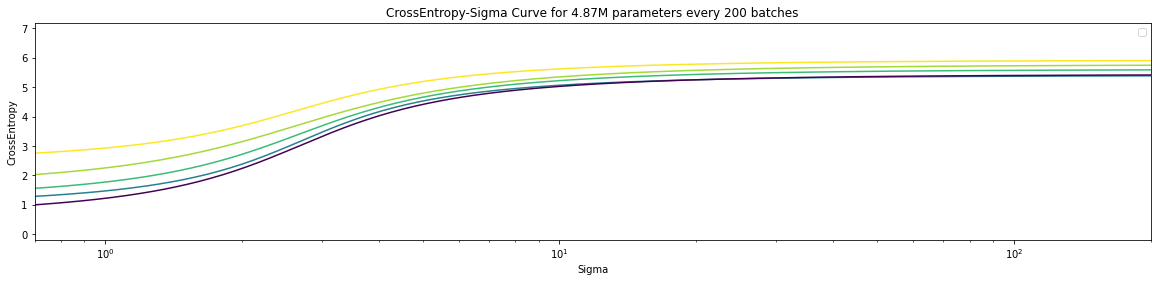

lr: 5.996376811594203e-05


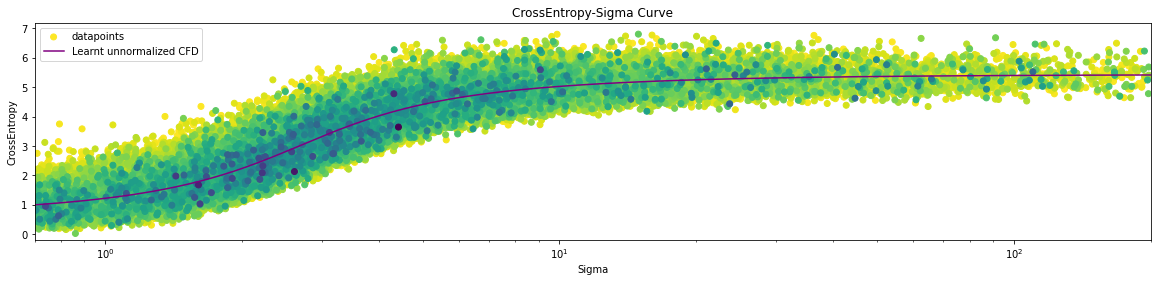

1028it [02:34,  6.65it/s]


KeyboardInterrupt: 

In [5]:
schedule_update_frequency=200
plotting_frequency=200

from IPython.display import clear_output
from tqdm import tqdm
model.train()
for epoch in range(n_epochs):  # Define num_epochs
    for i,batch in tqdm(enumerate(train_loader)):

        optimizer.zero_grad()  
        tokens = batch['input_ids'].to(device)
        prediction=model(tokens)

        loss = model.loss(prediction,tokens)
        loss.backward()
        optimizer.step()

        if i%plotting_frequency==0 or i%schedule_update_frequency==0:
            clear_output(wait=True) 

        if i%schedule_update_frequency==0 and i!=0:
            model.noise_schedule.update_optimal_parameters()
            model.noise_schedule.plot_training_curves(
                f'CrossEntropy-Sigma Curve for {(model.n_parameters/1e6):.2f}M parameters every {schedule_update_frequency} batches'
                )

        if i%plotting_frequency==0 and i!=0:
            lr_scheduler.step()
            print(f"lr: {lr_scheduler.get_last_lr()[0]}")
            model.noise_schedule.plot_entropy_time_curve()

In [7]:
out_embeddings=model.generate(1,64,1000)

100%|██████████| 999/999 [00:07<00:00, 126.48it/s]


In [9]:
from torch.distributions.categorical import Categorical


distrubution=Categorical(logits=out_embeddings)
sample=distrubution.sample()

# sample=logits.argmax(dim=-1)

tokenizer.batch_decode(sample)

['once [CLS] were there, there she day,mada was idea his brave. carrying [unused81] her amazement there seen with was the to flipped worst a lights andffy and, ruler to was.. her with dogg wanted wool and mom herए onion that mom. big paranoia her it " was it. he was [SEP]ration [SEP]']

: 

In [ ]:
model.noise_schedule.optimal_parameters

Parameter containing:
tensor([ 2.9710,  1.0772,  5.2757, -0.6213])

In [ ]:
torch.save(model.state_dict(),f'checkpoints/{(model.n_parameters/1e6):.2f}M_parameters.pt')